In [1]:
import numpy as np
from astropy.io import ascii
import os 
from tqdm import tqdm
from astropy.time import Time
import pandas as pd
import warnings
import time
import random
from gatspy import periodic, datasets
import matplotlib.pyplot as plt
from astropy.table import Table
from gatspy import datasets, periodic

import scipy.stats as sci_stat
import sys

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 250
rcParams['font.size'] = 20

global data_path
data_path = '../data/plasticc/data/'

# Caution, be careful when ignoring warnings!
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
def generate_toi_table(data, meta_info, meta_theta_EB, meta_theta_RRL):
    """
    Generate table that contains the light curve ID and transient type. 

    Input
    -----
    data: Head data table that contains photometry
    meta_info: Table that contains the meta-data (i.e classification name)
    meta_theta_<TYPE>: Table that contains metadata information (i.e Period)
    
    """
    id_av_rrl, id_av_eb = [], []

    for uid in tqdm(np.unique(data['object_id'])):
        ww = np.where(meta_theta_EB['object_id'] == uid)
        if np.shape(ww)[-1]==1:
            id_av_eb.append(uid)

    for uid in tqdm(np.unique(data['object_id'])):
        ww = np.where(meta_theta_RRL['object_id'] == uid)
        if np.shape(ww)[-1]==1:
            id_av_rrl.append(uid)

    id_av_rrl, id_av_eb = np.array(id_av_rrl), np.array(id_av_eb)

    _id1 = np.array(['rrl' for _ in range(len(id_av_rrl))])
    _id2 = np.array(['eb' for _ in range(len(id_av_eb))])

    # All ID's and & ID tags
    all_id = np.concatenate([id_av_rrl, id_av_eb])
    _id_all = np.concatenate([_id1, _id2])

    # Final TOI table
    toi_table = Table([all_id, _id_all], names=('obj_id', 'type'))

    return toi_table

In [3]:
# Read ALL PlastiCC data & meta
data = pd.read_csv(data_path + "plasticc_train_lightcurves.csv.gz",
                  compression='gzip',
                  error_bad_lines=False)

meta_info = ascii.read(data_path + "plasticc_train_metadata.csv") # ascii meta since it's smaller
meta_theta_EB = ascii.read(data_path + 'plasticc_modelpar/' + 'plasticc_modelpar_016_EB.csv')
meta_theta_RRL = ascii.read(data_path + 'plasticc_modelpar/' + 'plasticc_modelpar_092_RRL.csv')

# Fetch all toi's
toi_table = generate_toi_table(data, meta_info, meta_theta_EB, meta_theta_RRL)

# Helper functions to read and digest plasticc data

100%|██████████| 7848/7848 [00:00<00:00, 12676.53it/s]


In [18]:
def generate_lc(obj_id, band='all', data_table=data, det=1):
    """Unpack and return PlastiCC data in numpy array format.
    
    Input:
    ------
    obj_id: Object ID
    band: Photometric bandpass filter. 'all' includes ugrizy, or 'ugrizy'
    data_table: Pandas data table containing the light curves
    det: Detection from the image subtraction algorithm. ==1 detection, ==0 not detection (i.e upper limit) or 'all': uses both 0 & 1
    """
    
    if det==0 or det==1:
        data_table_mod = data_table[data_table['detected_bool']==det]
    elif det=='all':
        data_table_mod = data_table # select both 
        
    # Select light curve based on the ID 
    lc = data_table_mod[data_table_mod['object_id']==obj_id]
    
    lsst_bands = list('ugrizy') # lsst photomeric bands
    
    lc_array = lc.to_numpy()

    # Capture empty light curve
    assert len(lc_array[:,1])>0, ("Sorry, it seems like your obj_id query was wrong!")

    mjd, flux, flux_err = lc_array[:,1], lc_array[:,3], lc_array[:,4]
    flt = lc_array[:,2].astype(int).astype(str)    
    
    for j in range(6):
        flt[flt==str(j)] = lsst_bands[j]
    
    if band=='all':
        return mjd, flux, flux_err, flt
    else:
        return mjd[flt==band], flux[flt==band], flux_err[flt==band], flt[flt==band]
     

def fetch_type(lid, table=toi_table):
    """Fetch the classification type of transient given light curve table and original head TOI table."""
    return table[table['obj_id']==lid]


def fetch_meta_info(lc_id, lc_type):
    """Fetch metadata for transient type.
    
    Input
    -----
    lc_id: Light curve ID 
    lc_type: classification type (i.e rrl, eb)

    Output
    ------
    meta_<type>_table: Table that contains metadata (i.e period and other physical properties)
    """
    if lc_type=='rrl':
        # crossmatch to approprirate table
        xm_ = np.where(meta_theta_RRL['object_id']==lc_id)
        return meta_theta_RRL[xm_]
    elif lc_type=='eb':
        # crossmatch to approprirate table
        xm_ = np.where(meta_theta_EB['object_id']==lc_id)
        return meta_theta_EB[xm_]

# Write a function that will generate N random from each class (equal)
def draw_rand_trans(table, N=10, class_type='rrl'):
    """Given N this function will draw an equal number of trnasinets.
       Note: It will not draw the same transiennt
    """
    # isolate each unique class
    req_tab = table[table['type']==class_type]  
    
    # Random number generator w/o repeat
    rng = np.random.default_rng()
    rn = rng.choice(len(req_tab), size=N, replace=False)
    
    return req_tab[rn]  

def run_multi_lsp(x, y, err, fts, fmin=0.1, fmax=150, k=1, mode='fast', dt_cut=365, k_term_base=0, mode_return='bp'):
    """Run all methods of multiband gatspy Lomb-Scargle Periodogram. 

        Input
        ------
        x, y, err, fts: phase, magnitudes/flux, error, filter list
        fmin, fmax: minimum and maximum search period in the Lomb-Scargle
        k (int): Number of Fourier components
        mode (str): LSP method. Currently supports 'fast' and "general"
        dt_cut (int): Maximum baseline time. Default is 1 year worth of photometry.

        Output
        ------
        best_period: Best period found from the highest peak in the LSP
        TODO: False Alarm Probability, TOP N peaks?!
    """
    
    try:
        # Pre-processing to photometry
        dt = x-x[0] # calculate baseline
        x, y, err, fts = x[dt<=dt_cut], y[dt<=dt_cut], err[dt<=dt_cut], fts[dt<=dt_cut]
        y += -1*min(y) # TODO: PLASTICC light curves can be negative. For now normalize such that they're at least positive
        dt = x-x[0] # evaluate baseline again!
        # Check fmax limit
        if max(dt)<fmax:
            fmax = max(dt)-3
    except:
        return np.nan
    
    if mode=='fast':
        try:
            model = periodic.LombScargleMultibandFast(fit_period=True,optimizer_kwds={"quiet": True},
                                  Nterms=k)
            model.optimizer.set(period_range=(fmin, fmax))
            model = model.fit(x, y, dy=err, filts=fts)
            if mode_return=='bp':
                return model.best_period
            elif mode_return=='model':
                return model
        except:
            return np.nan
    elif mode=='general':
        try:
            model = periodic.LombScargleMultiband(fit_period=True,optimizer_kwds={"quiet": True},
                      Nterms_base=k_term_base, Nterms_band=k)
            model.optimizer.set(period_range=(fmin, fmax))
            model = model.fit(x, y, dy=err, filts=fts)
            if mode_return=='bp':
                return model.best_period
            elif mode_return=='model':
                return model
        except:
            return np.nan
        

def run_single_lsp(x, y, err, fts, band='u', fmin=0.1, fmax=150, k=1, mode='fast', dt_cut=365, mode_return='bp'):
    """Run all methods of single-band gatspy Lomb-Scargle Periodogram. 

        Input
        ------
        x, y, err, fts: phase, magnitudes/flux, error, filter list
        band (str): Photometric band you want to run LSP. Currently supports 'ugrizy'.
        fmin, fmax: minimum and maximum search period in the Lomb-Scargle
        k (int): Number of Fourier components
        mode (str): LSP method. Currently supports 'fast' and "general"
        dt_cut (int): Maximum baseline time. Default is 1 year worth of photometry.
        mode_return (str): What do you want to return? 'bp': best period, 'model': return gastpy model

        Output
        ------
        best_period: Best period found from the highest peak in the LSP
        TODO: False Alarm Probability, TOP N peaks?!
    """
    
    try:
        # Pre-processing to photometry
        dt = x-x[0] # calculate transient duration
        x, y, err, fts = x[dt<=dt_cut], y[dt<=dt_cut], err[dt<=dt_cut], fts[dt<=dt_cut]
        y += -1*min(y)
        dt = x-x[0] # updated dt
        
        # isolate photometric band
        x, y, err = x[fts==band], y[fts==band], err[fts==band]
        
        # Check fmax limit
        if max(dt)<fmax:
            fmax = max(dt)-5 
        
    except:
        return np.nan
    
    if mode=='fast':
        try:
            model = periodic.LombScargleFast(fit_period=True,optimizer_kwds={"quiet": True},
                                  Nterms=1)
            model.optimizer.set(period_range=(fmin, fmax))
            model = model.fit(x, y, dy=err)
            if mode_return=='bp':
                return model.best_period
            elif mode_return=='model':
                return model
        except:
            return np.nan
    elif mode=='general':
        try:
            model = periodic.LombScargleMultiband(fit_period=True,optimizer_kwds={"quiet": True},
                      Nterms_base=k)
            model.optimizer.set(period_range=(fmin, fmax))
            model = model.fit(x, y, dy=err)
            if mode_return=='bp':
                return model.best_period
            elif mode_return=='model':
                return model
        except:
            return np.nan
  

def generate_tags(kmax):
    """Generate titles for master table on LSP analysis"""
    # Create data table
    m_lsp_name_fast_list = []
    m_lsp_name_gen_list = []
    for i in range(kmax):
        m_lsp_name_fast_list.append('multi_lsp_f'+f'{i+1}')
        m_lsp_name_gen_list.append('multi_lsp_g'+f'{i+1}')
        
    s_lsp_gen_list = []
    for iii in range(kmax):
        for jj, band_name in enumerate(list('ugrizy')):
            s_lsp_gen_list.append('s_lsp_g'+f'{iii+1}'+f'_{band_name}')
            
    s_lsp_fast_list = [] 
    for band_name in list('ugrizy'):
        s_lsp_fast_list.append(f's_lsp_f_{band_name}')
        
    master_names = np.concatenate([['id'], ['ndet'], ['ptrue'], m_lsp_name_fast_list, m_lsp_name_gen_list, s_lsp_gen_list, s_lsp_fast_list])
    
    return master_names

In [24]:
draw_rand_trans(toi_table, N=5, class_type='eb')

obj_id,type
int64,str3
20615291,eb
5072263,eb
9908199,eb
48407508,eb
281273,eb


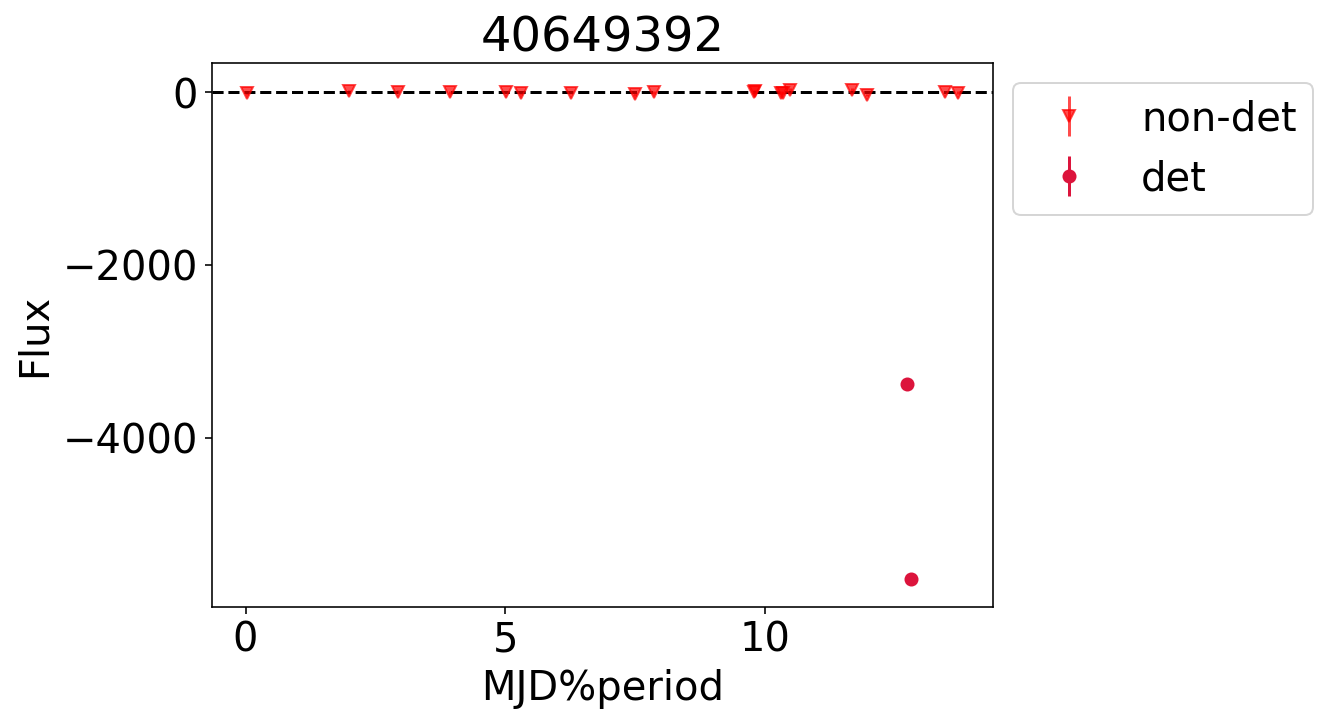

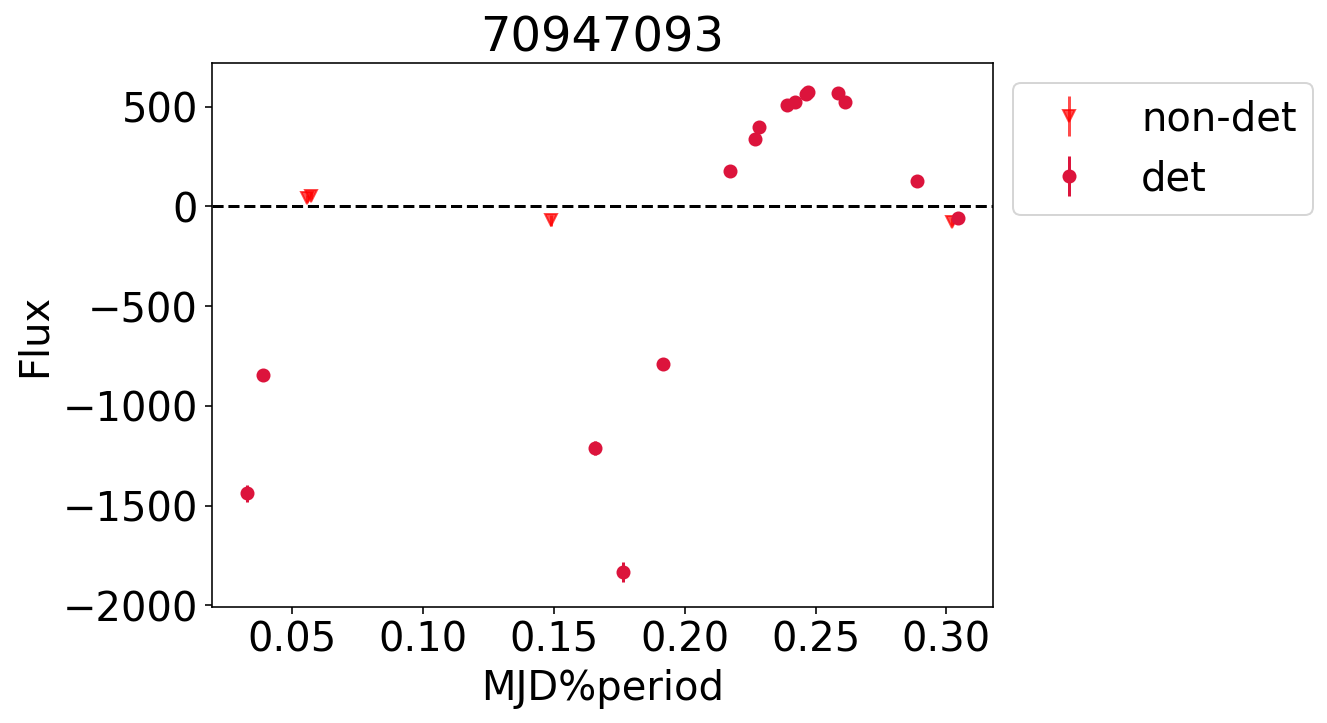

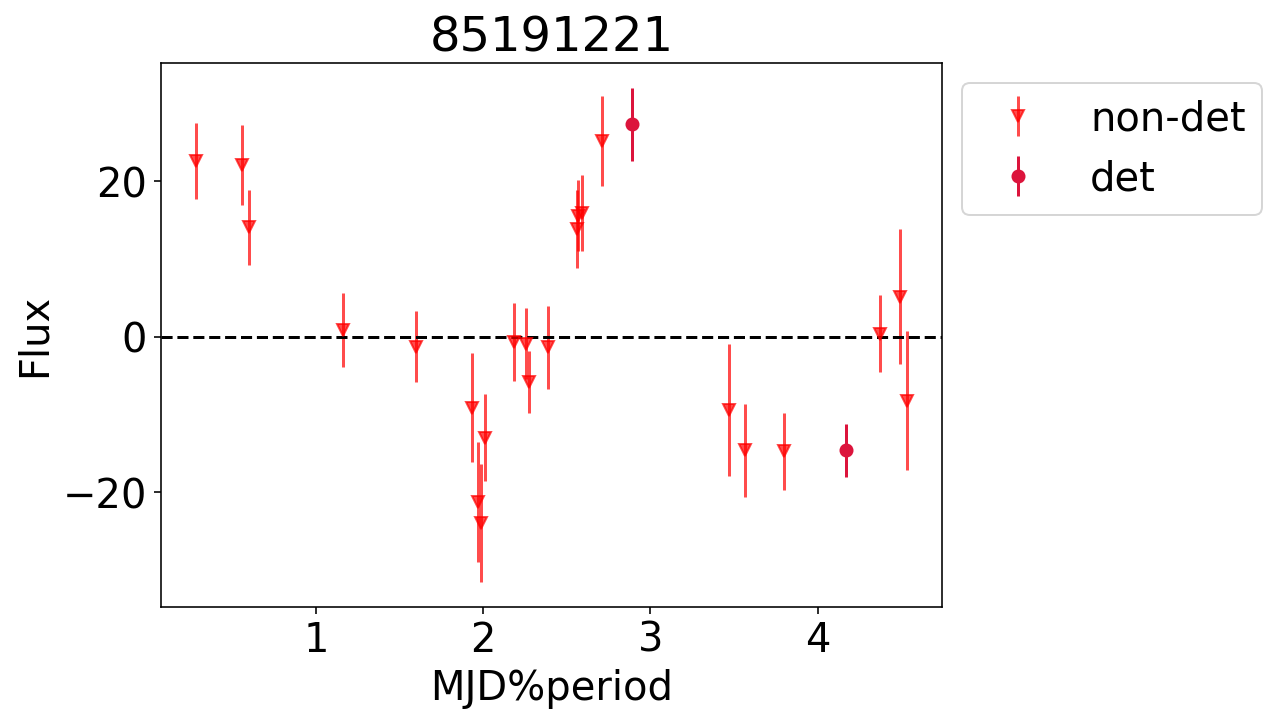

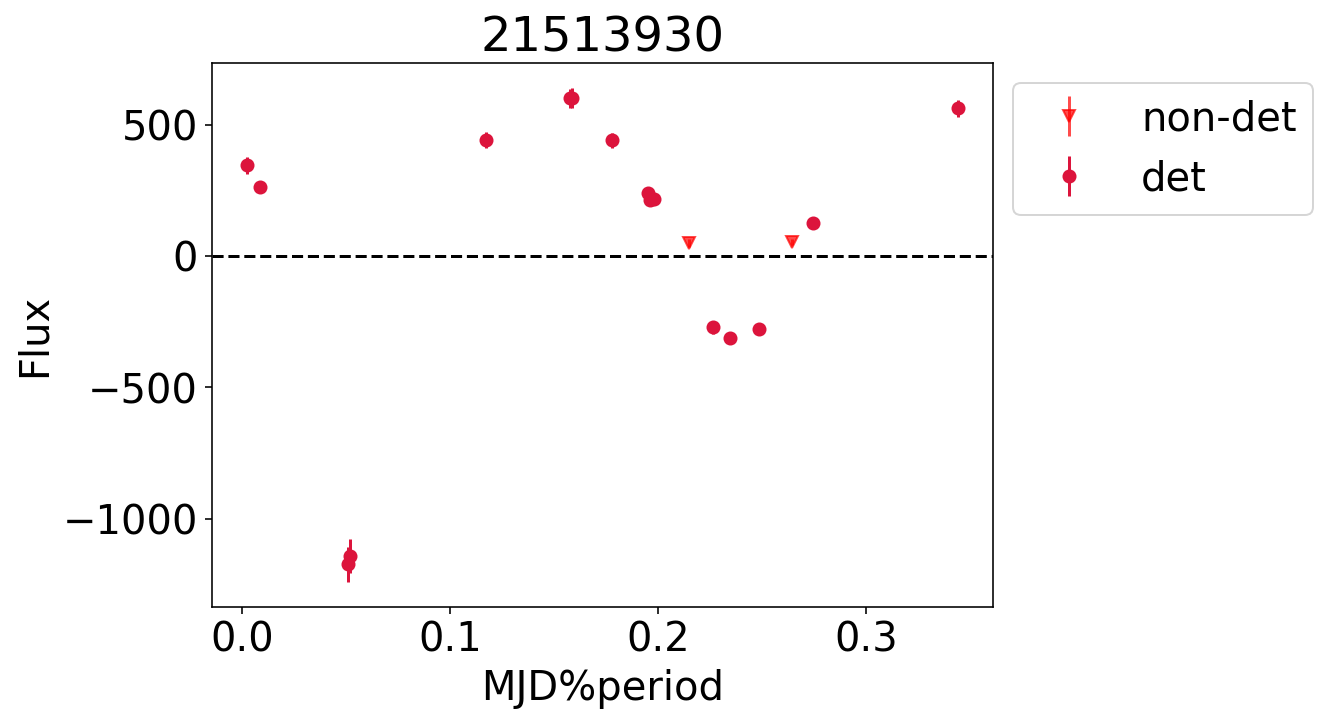

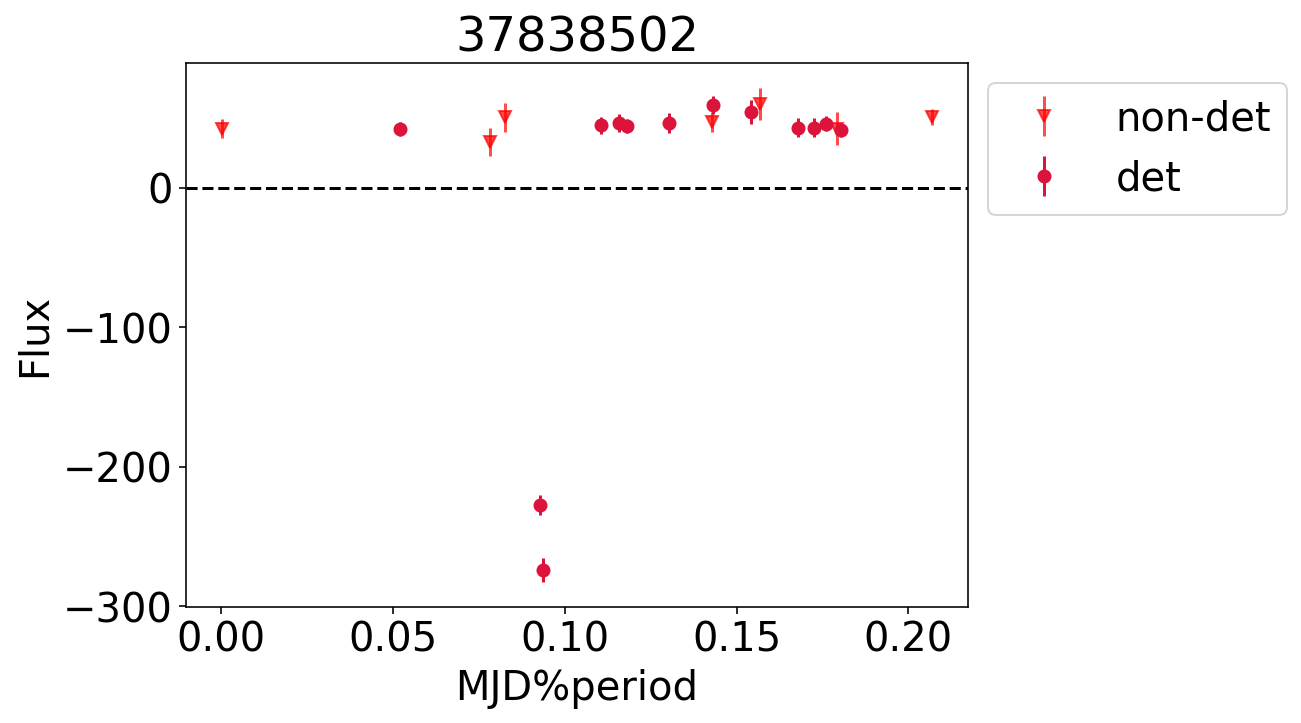

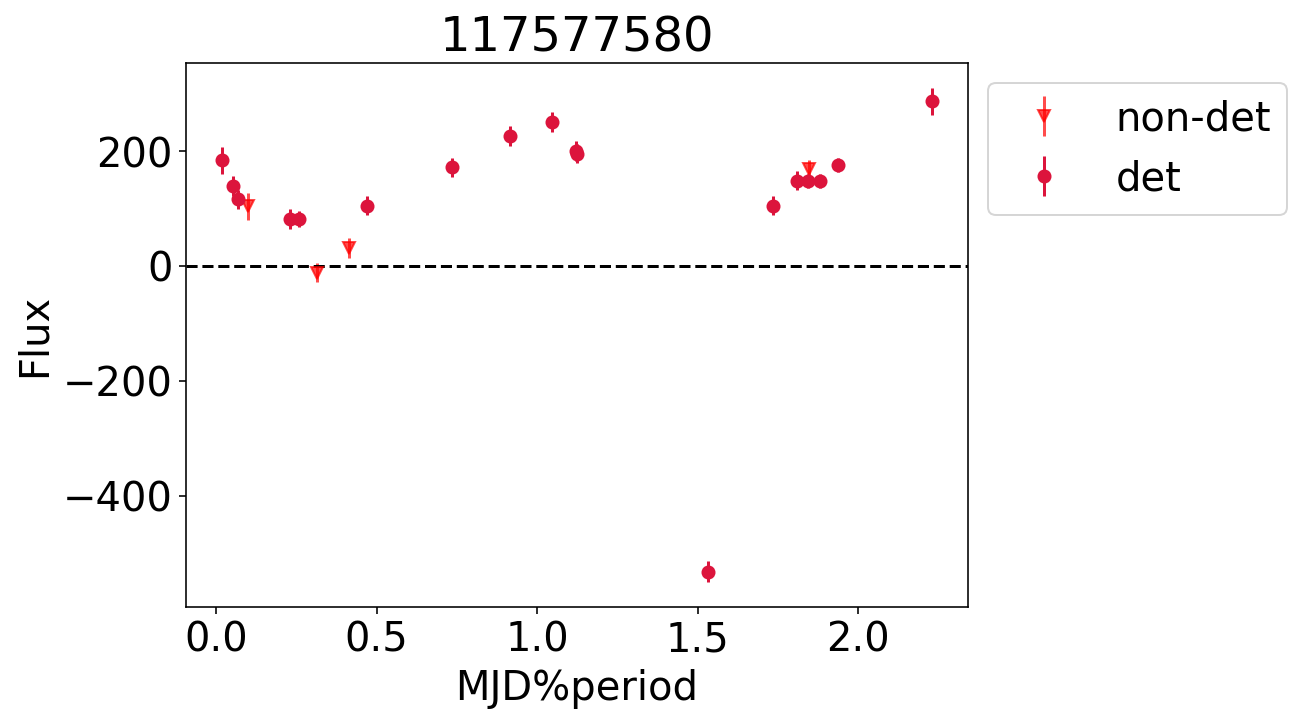

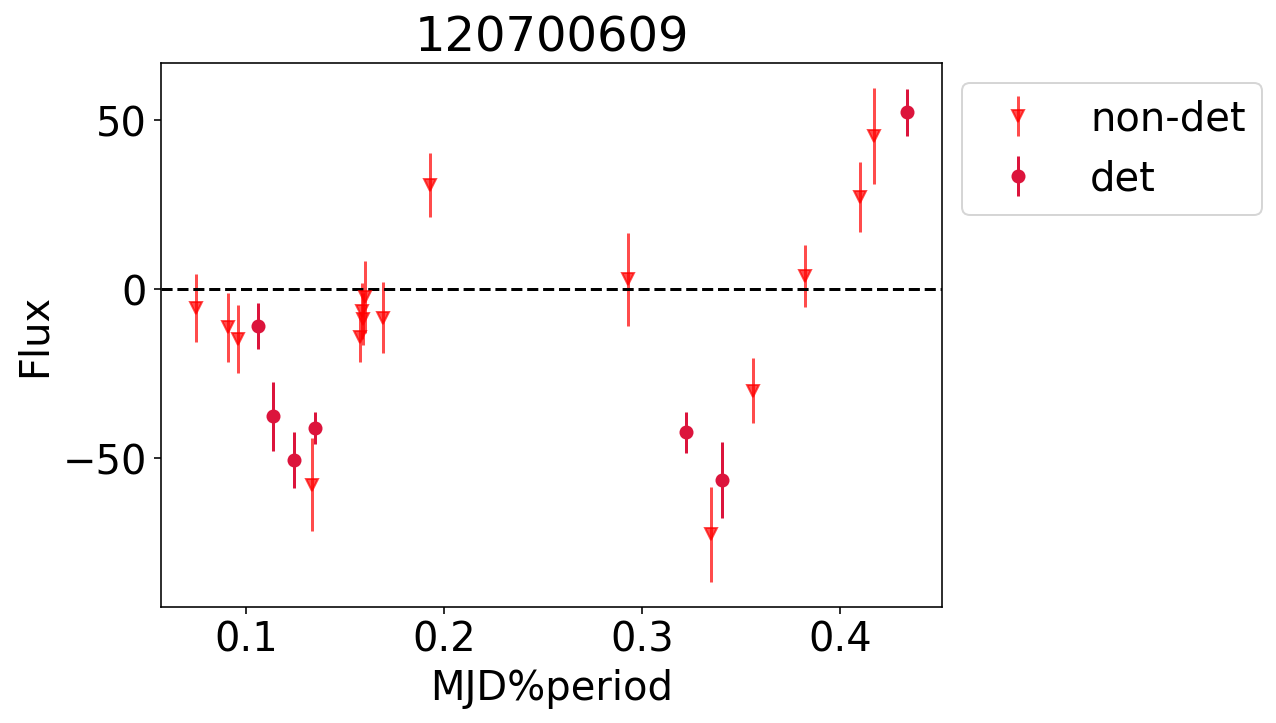

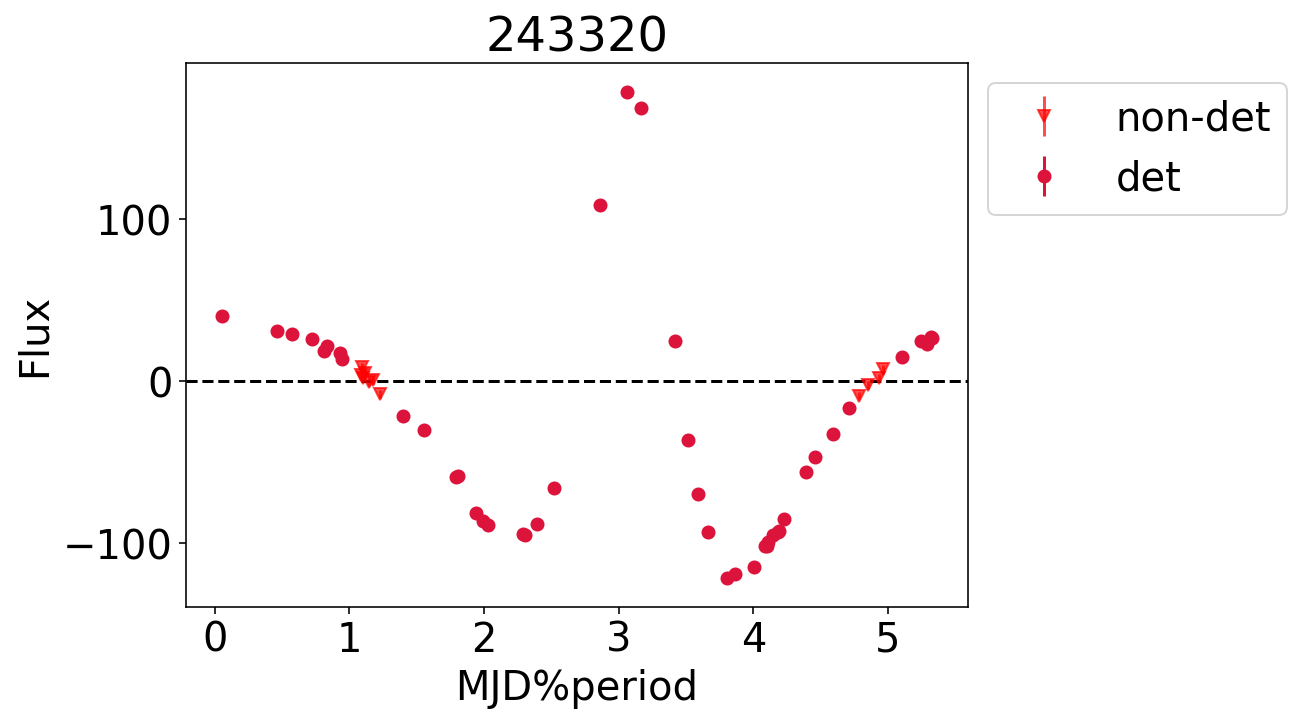

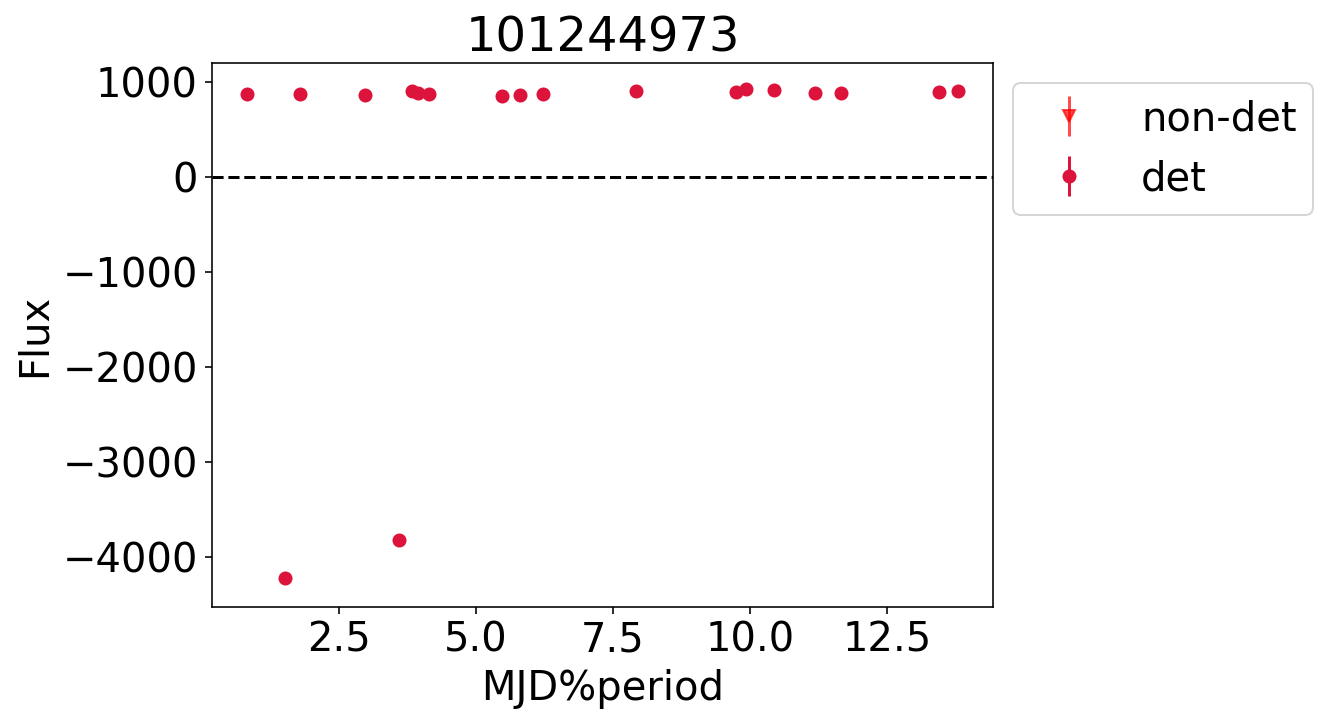

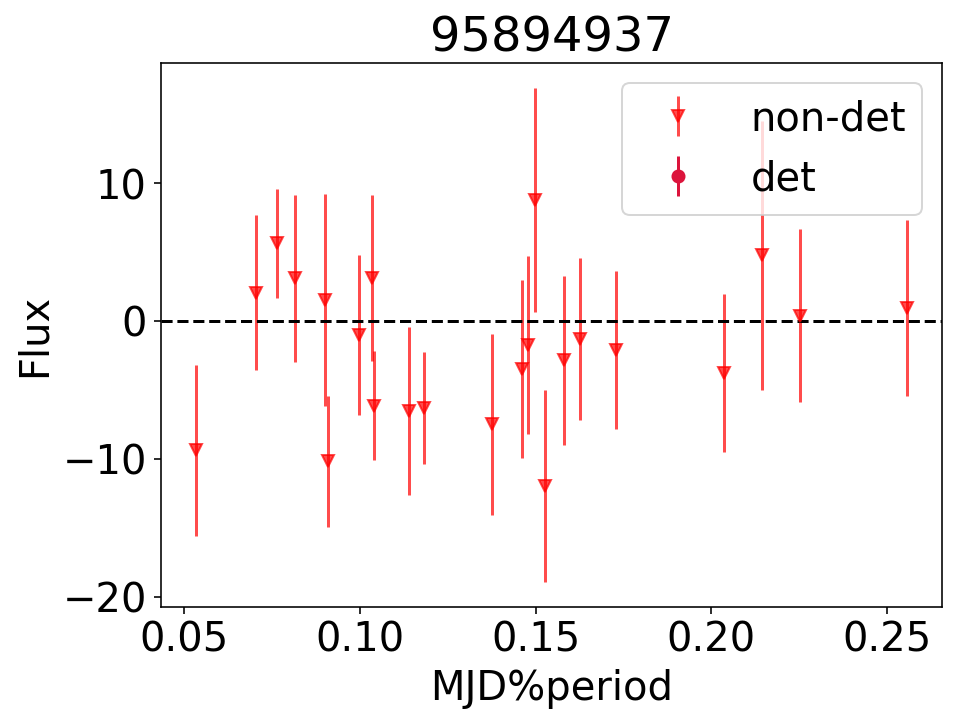

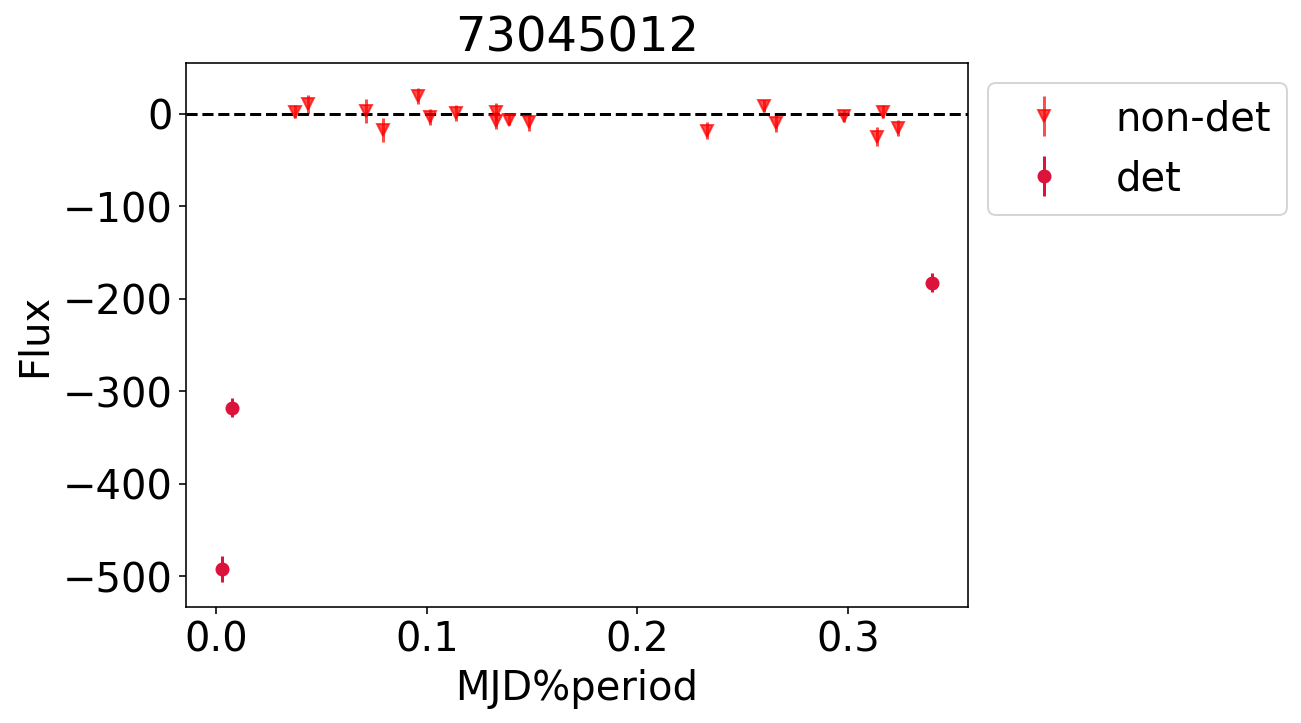

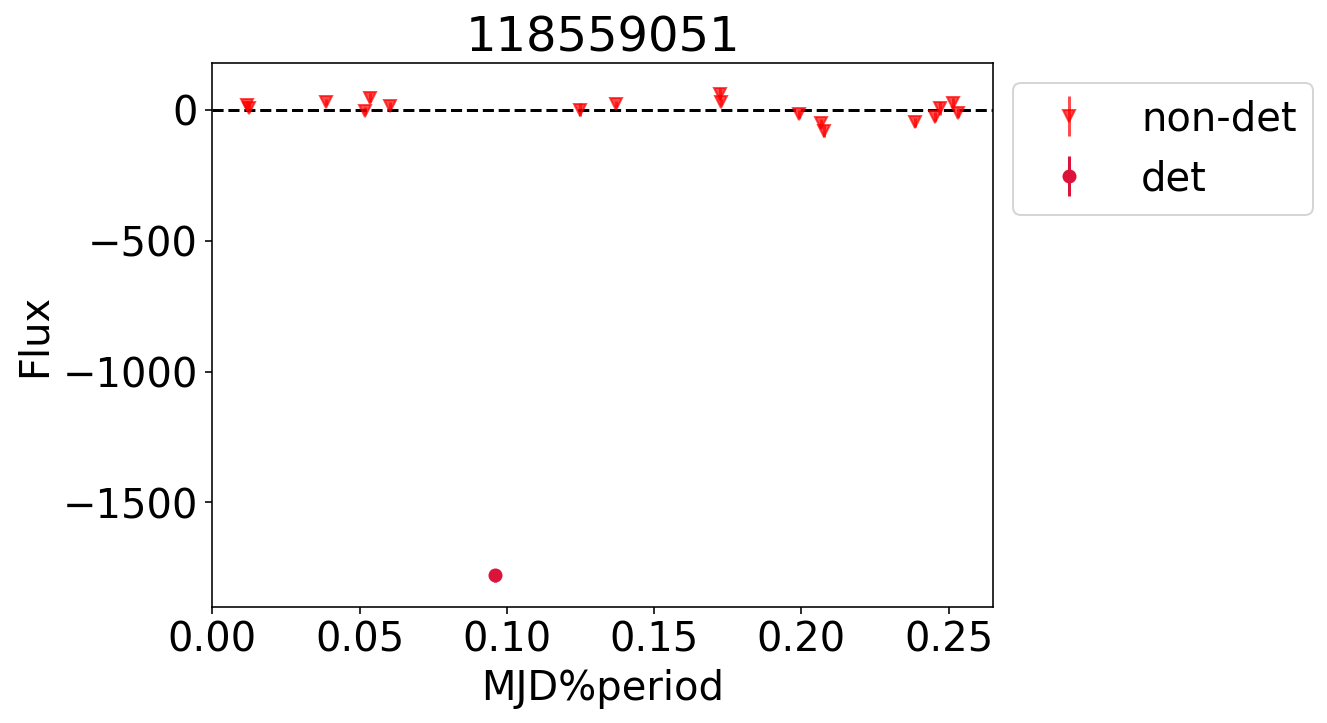

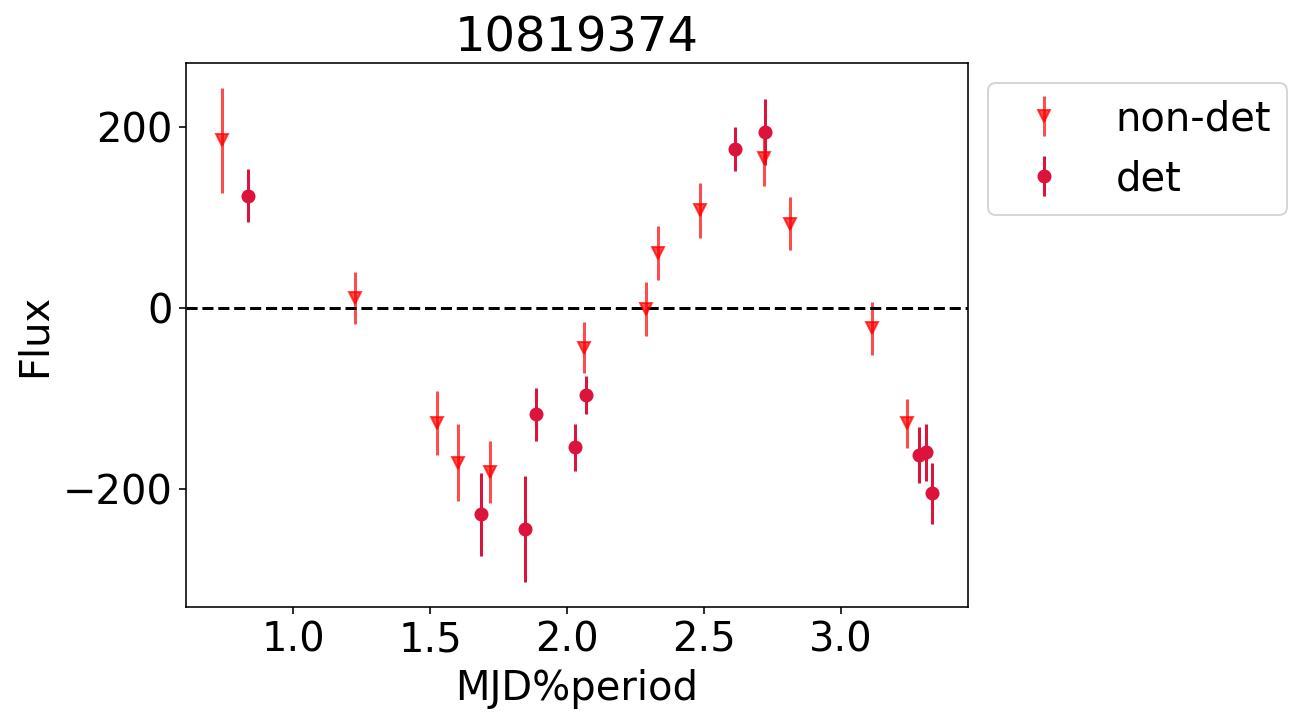

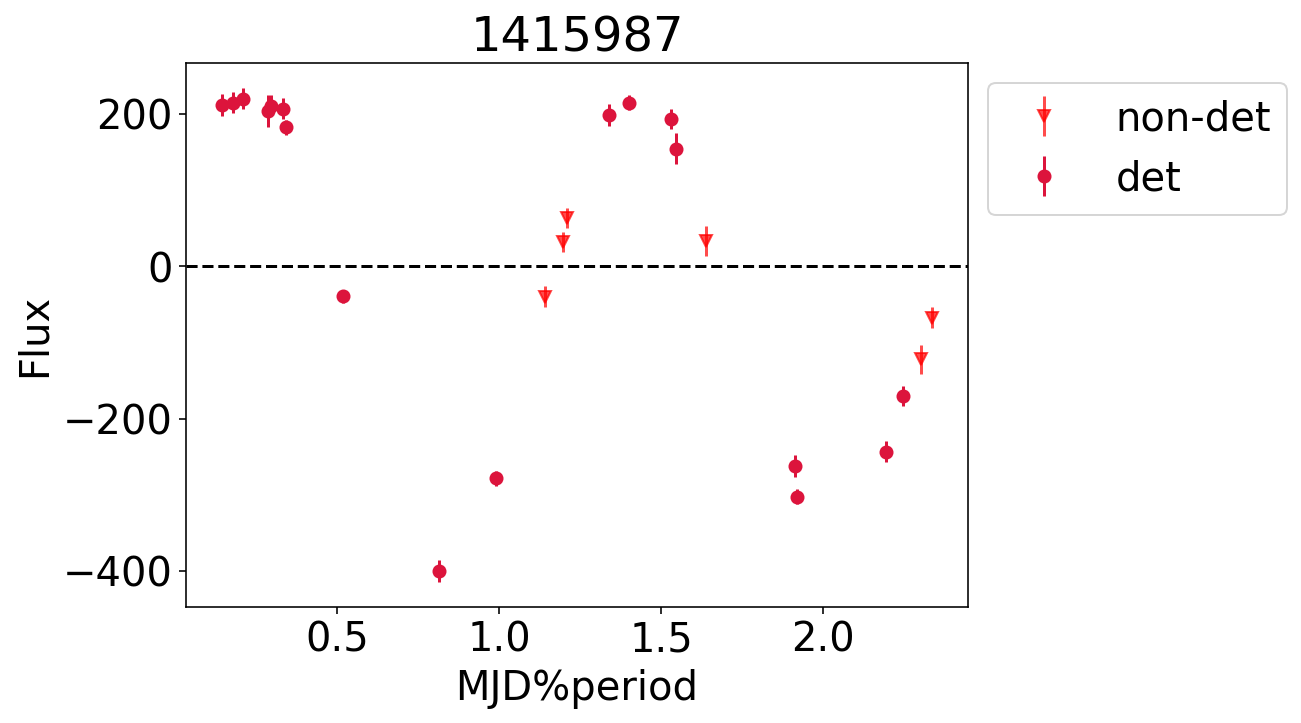

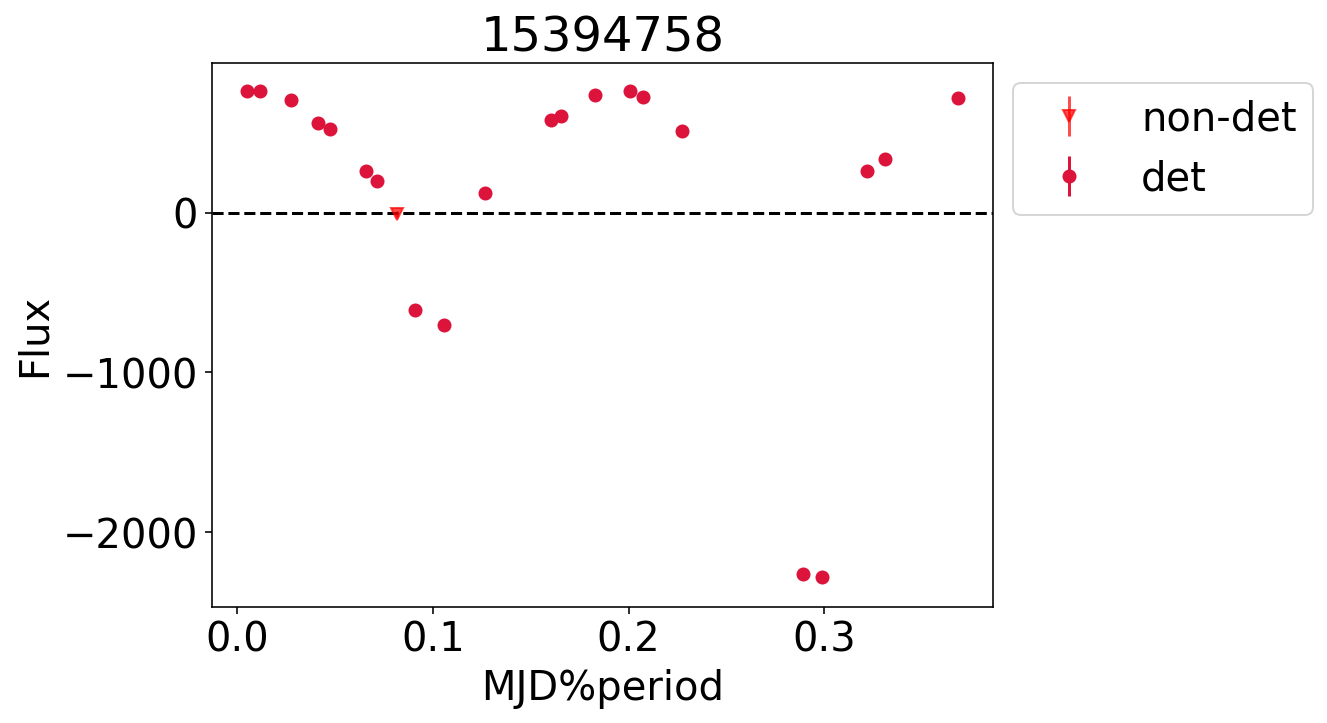

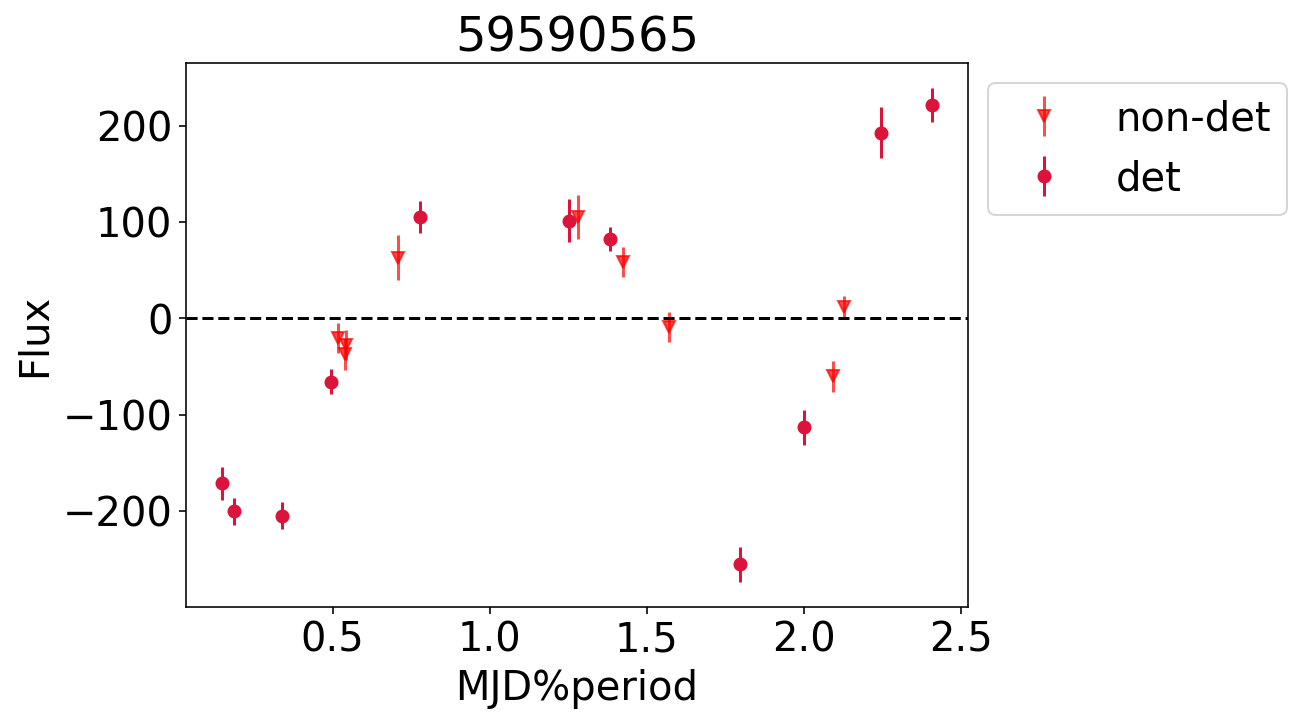

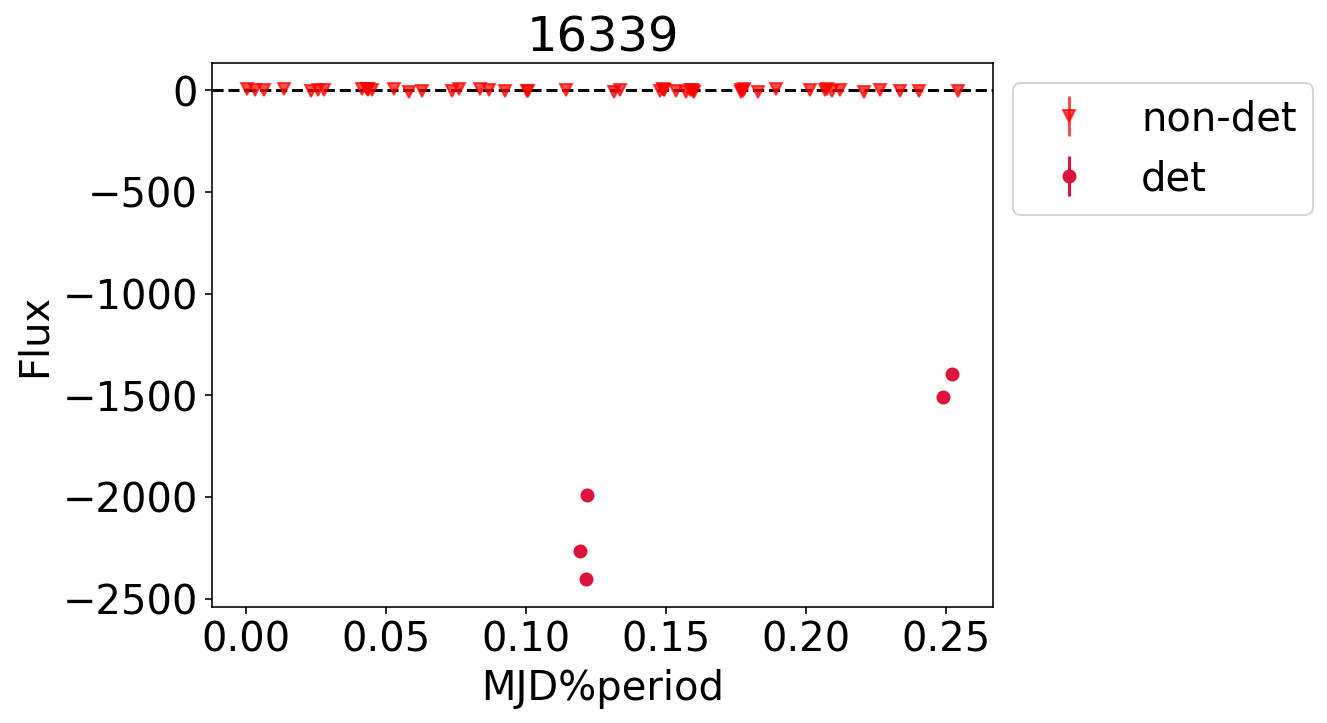

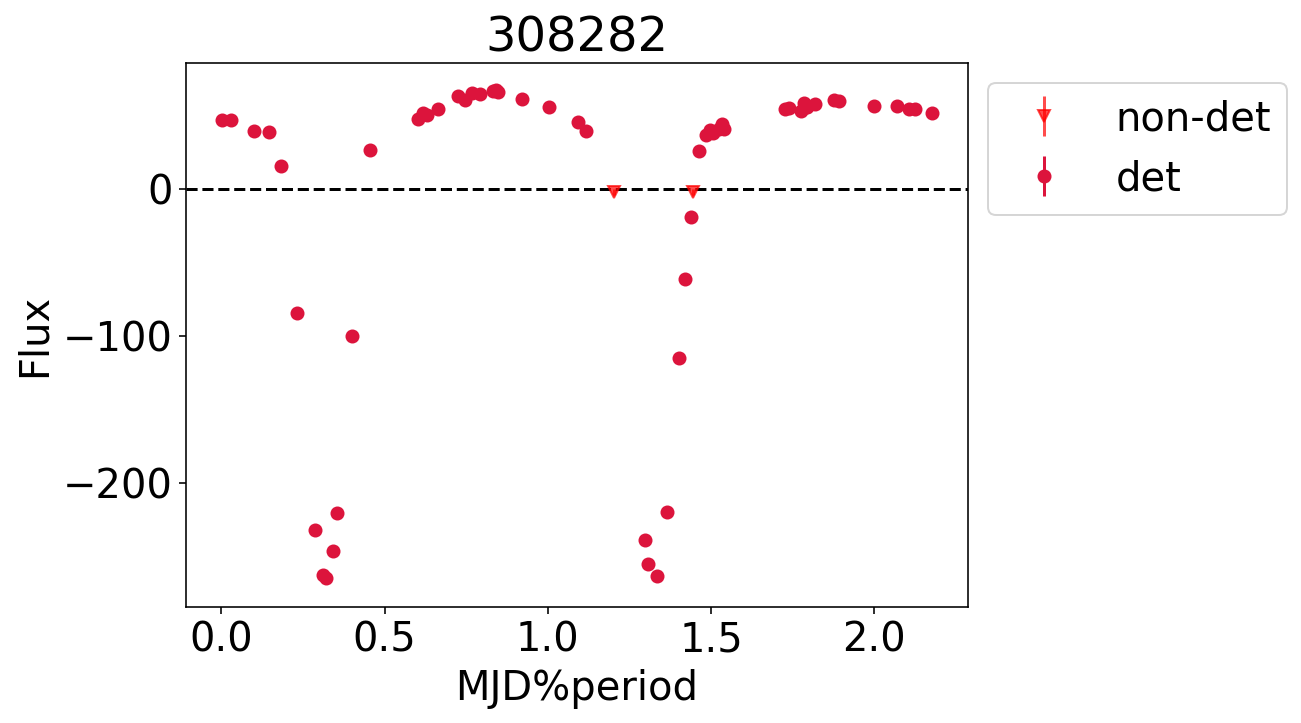

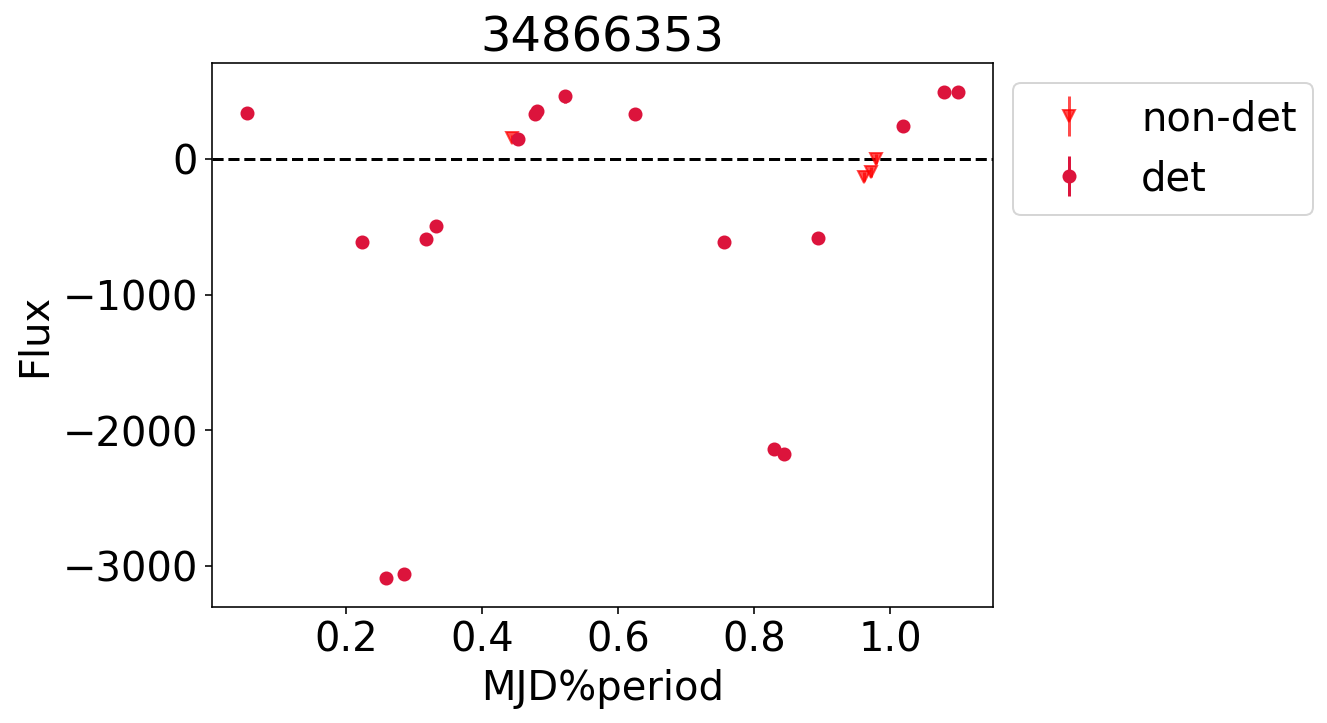

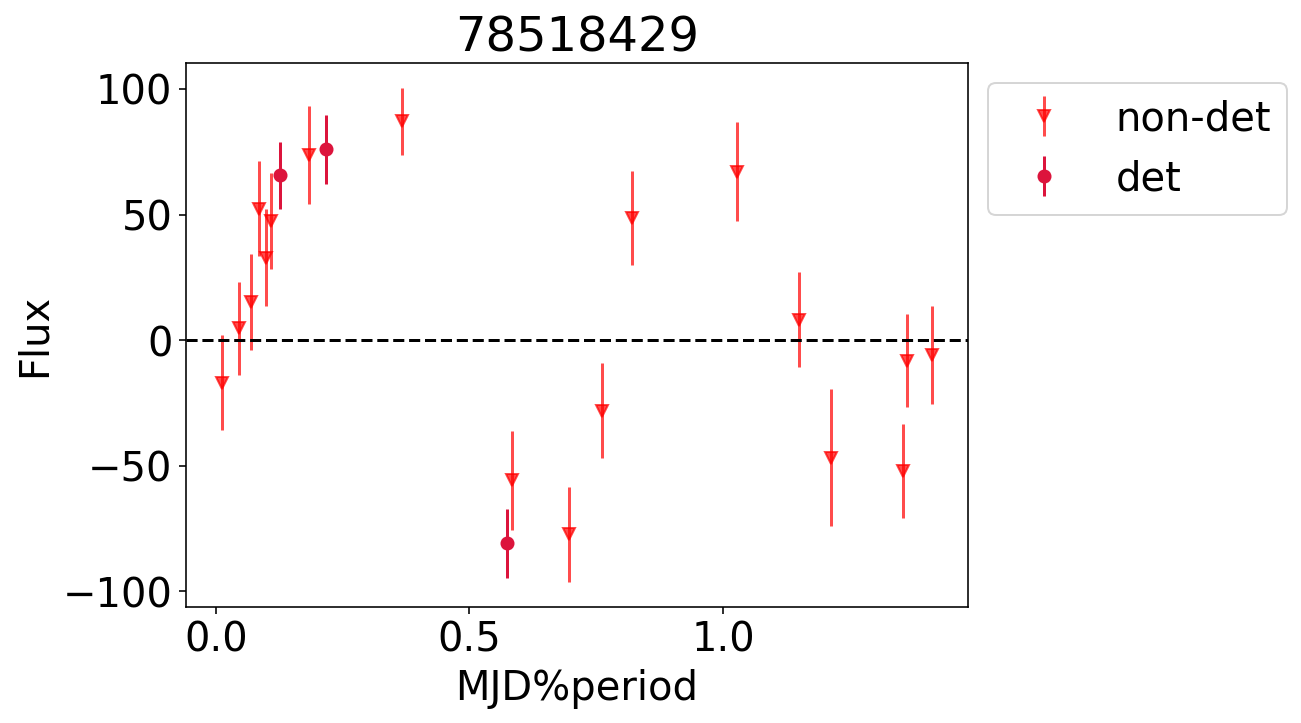

In [55]:


for p in draw_rand_trans(toi_table, N=20, class_type='eb')['obj_id']:


    id_i = p


    lc_0 = generate_lc(id_i, band='r', data_table=data, det=0)
    lc_1 = generate_lc(id_i, band='r', data_table=data, det=1)

    plt.figure(figsize=(7,5))
    plt.errorbar(lc_0[0]%fetch_meta_info(id_i, 'eb')['PERIOD'].data[0], 
                 lc_0[1], yerr=lc_0[2], fmt='v', label='non-det', color='red', alpha=0.7)
    plt.errorbar(lc_1[0]%fetch_meta_info(id_i, 'eb')['PERIOD'].data[0],
                 lc_1[1], yerr=lc_1[2], fmt='o', label='det', color='Crimson')
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(id_i)
    plt.xlabel("MJD%period")
    plt.ylabel("Flux")

    plt.axhline(0, color='k', ls='--')

In [36]:
fetch_meta_info(48407508, 'eb')['PERIOD'].data[0]

2.4461

<ErrorbarContainer object of 3 artists>

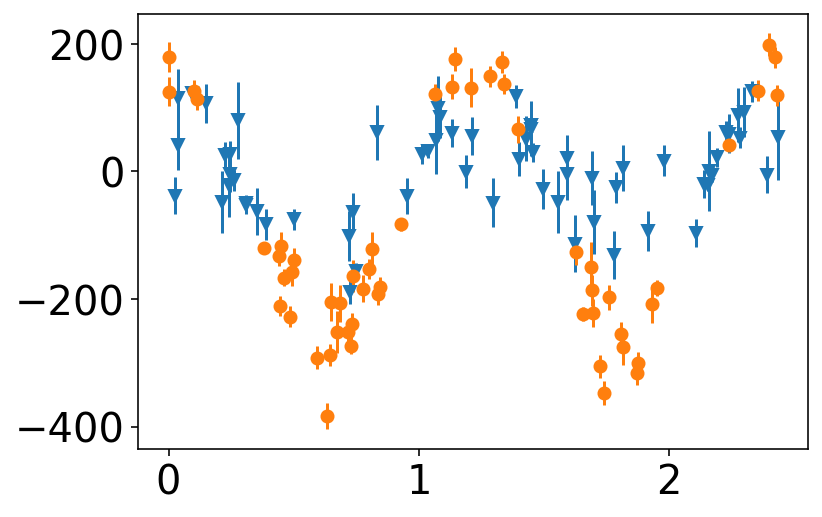

In [33]:
lc_0 = generate_lc(48407508, band='all', data_table=data, det=0)
lc_1 = generate_lc(48407508, band='all', data_table=data, det=1)

plt.errorbar(lc_0[0]%2.4461, lc_0[1], yerr=lc_0[2], fmt='v')
plt.errorbar(lc_1[0]%2.4461, lc_1[1], yerr=lc_1[2], fmt='o')


# 0: is upper limit
# 1: is det

In [619]:
lc_t = np.concatenate([x[0], xx[0]])
lc_m = np.concatenate([x[1], xx[1]])
lc_merr = np.concatenate([x[2], xx[2]])
lc_ft = np.concatenate([x[3], xx[3]])

In [557]:
#lc_t, lc_m, lc_merr, lc_ft = generate_lc(80301529, band='all')
#lc_m += -1*min(lc_m)

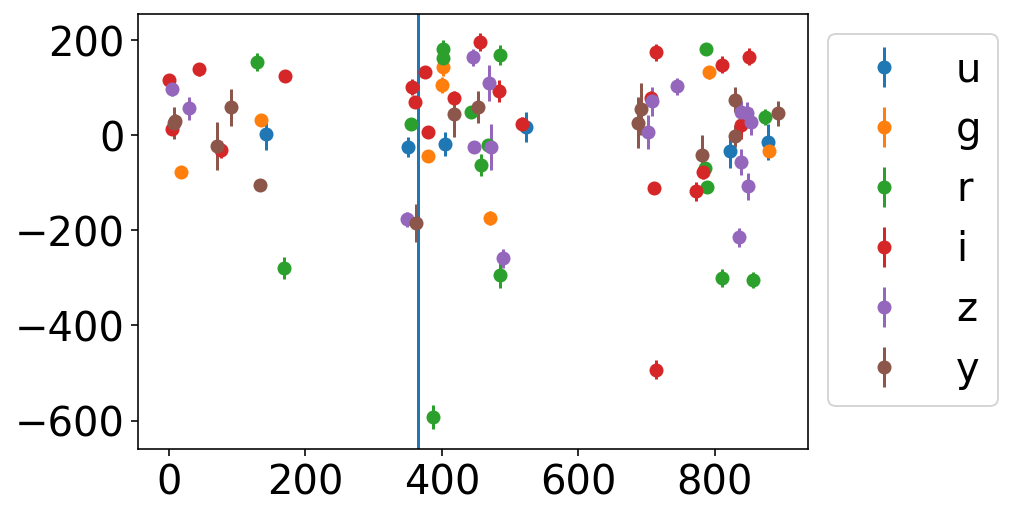

In [620]:
for i in list('ugrizy'):
    plt.errorbar(lc_t[lc_ft==i]-lc_t[0], lc_m[lc_ft==i], lc_merr[lc_ft==i], 
                fmt='o', label=i)
plt.legend(bbox_to_anchor=(1,1))
plt.axvline(365)

In [621]:
fetch_meta_info(80301529, 'eb')

object_id,submodel,sim_av,PERIOD,TRAT,RSUM,ECOSW,ESINW,COSI,Q,FF
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
80301529,1,0,5.0142,1.2466,0.3912,-0.0013,0.0316,0.0853,0.8248,-0.7774


In [663]:
lsp_multi = run_multi_lsp(lc_t, lc_m, lc_merr, lc_ft, k=1, mode='general', 
                          k_term_base=0, fmax=100, dt_cut=365*1, fmin=0.1, mode_return='bp')

lsp_single = run_single_lsp(lc_t, lc_m, lc_merr, lc_ft, band='r', k=1, mode='general', dt_cut=365*1)


In [664]:
print (lsp_multi, lsp_single)

0.14118323438881256 0.14768636239120306


Text(0.5, 1.0, 'True Period')

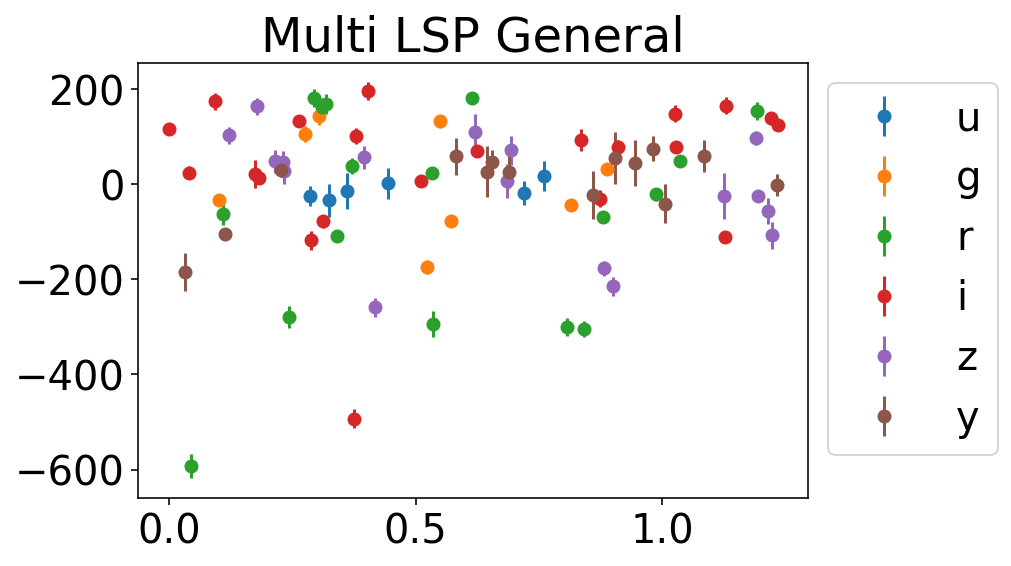

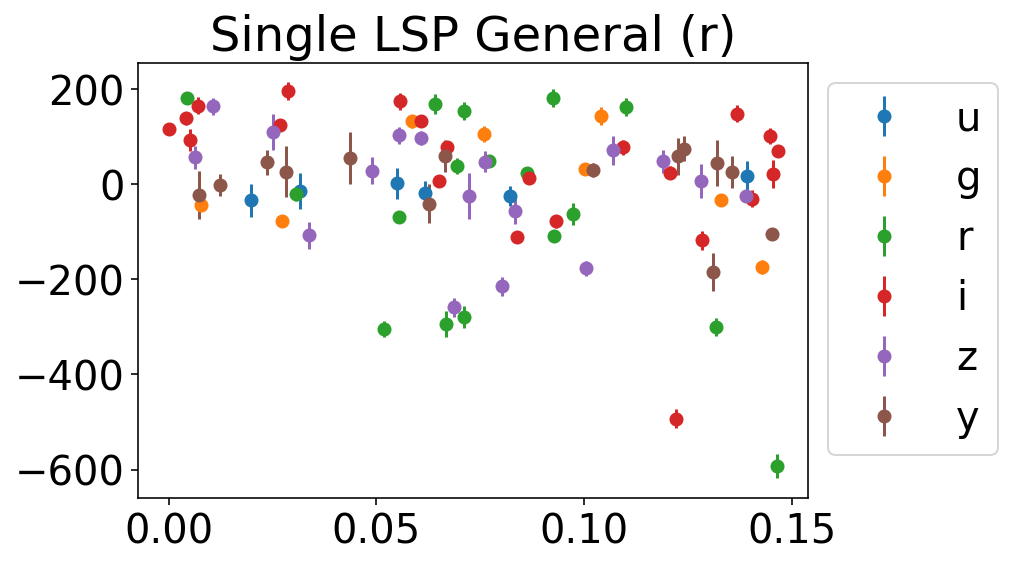

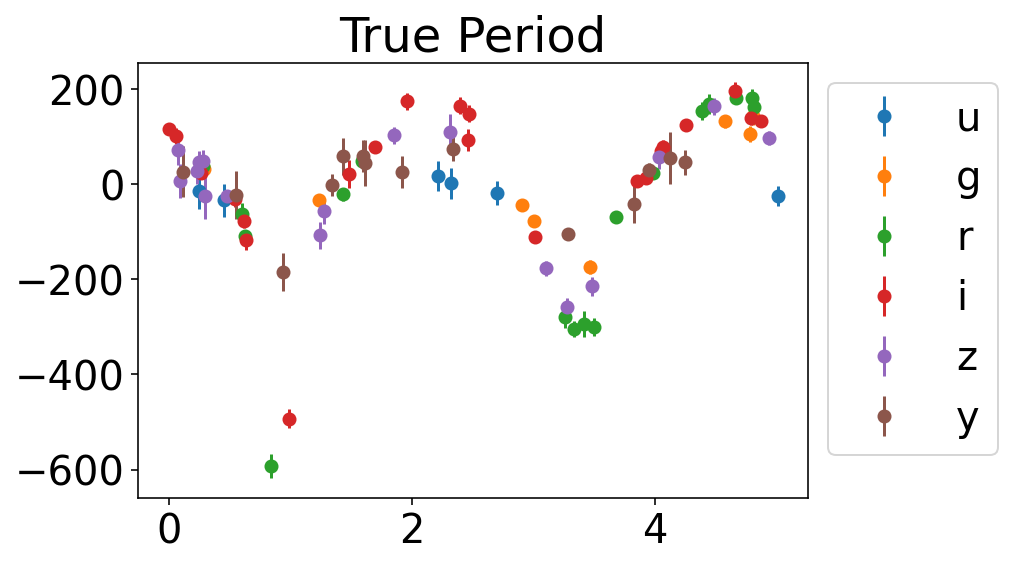

In [662]:
plt.figure()
for i in list('ugrizy'):
    plt.errorbar((lc_t[lc_ft==i]-lc_t[0])%lsp_multi, lc_m[lc_ft==i], lc_merr[lc_ft==i], 
                fmt='o', label=i)
plt.legend(bbox_to_anchor=(1,1))
plt.title("Multi LSP General")


plt.figure()
for i in list('ugrizy'):
    plt.errorbar((lc_t[lc_ft==i]-lc_t[0])%lsp_single, lc_m[lc_ft==i], lc_merr[lc_ft==i], 
                fmt='o', label=i)
plt.legend(bbox_to_anchor=(1,1))
plt.title("Single LSP General (r)")

plt.figure()

for i in list('ugrizy'):
    plt.errorbar((lc_t[lc_ft==i]-lc_t[0])%5.0142, lc_m[lc_ft==i], lc_merr[lc_ft==i], 
                fmt='o', label=i)
plt.legend(bbox_to_anchor=(1,1))
plt.title("True Period")

#plt.axvline(365)

height at correct 0.99730179297051
height at recovered 0.9999863344621679


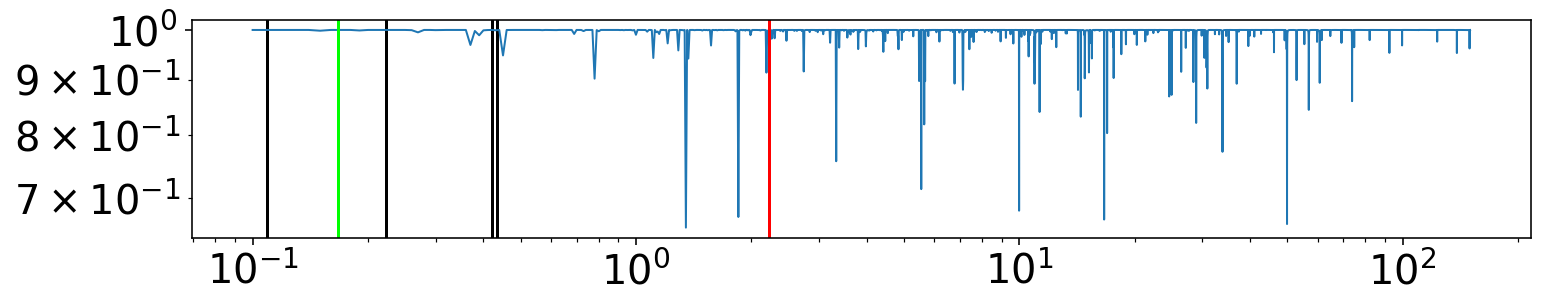

In [533]:
NN = 0.01
h = lsp_multi.periodogram(np.arange(0.1, 150, step=NN))
print ('height at correct',lsp_multi.periodogram(2.2271))
print ('height at recovered',lsp_multi.periodogram(lsp_multi.best_period))

plt.figure(figsize=(12,2))

for j in lsp_multi.find_best_periods(n_periods=5, return_scores=False):
    plt.axvline(j, color='k')


plt.plot(np.arange(0.1, 150, step=NN), h, lw=1)
plt.axvline(2.2271, color='red')
plt.axvline(lsp_multi.best_period, color='lime')
plt.xscale('log')
plt.yscale('log')



AttributeError: 'numpy.float64' object has no attribute 'predict'

<ErrorbarContainer object of 3 artists>

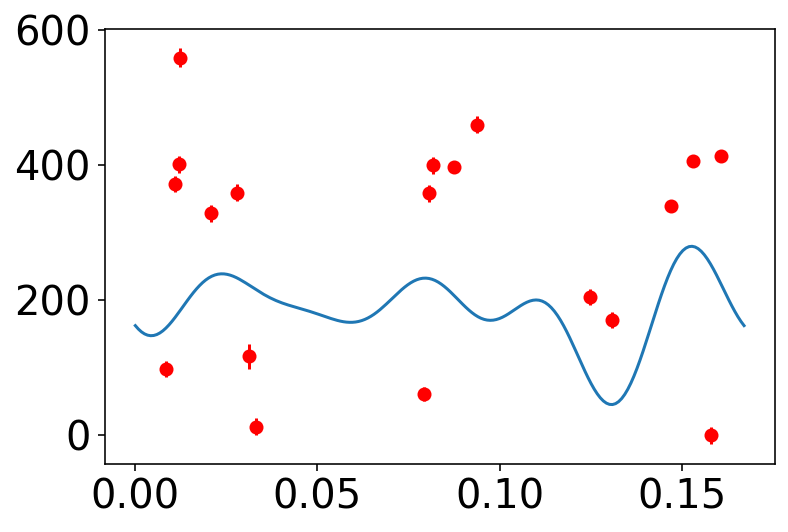

In [537]:
plt.plot(tt, mf)
plt.errorbar((lc_t[lc_ft=='r']%lsp_multi.best_period), lc_m[lc_ft=='r'], lc_merr[lc_ft=='r'], 
            fmt='o', color='red')

In [378]:
lsp_multi, 

(0.3273722624616371, 0.24256330988220462)

<ErrorbarContainer object of 3 artists>

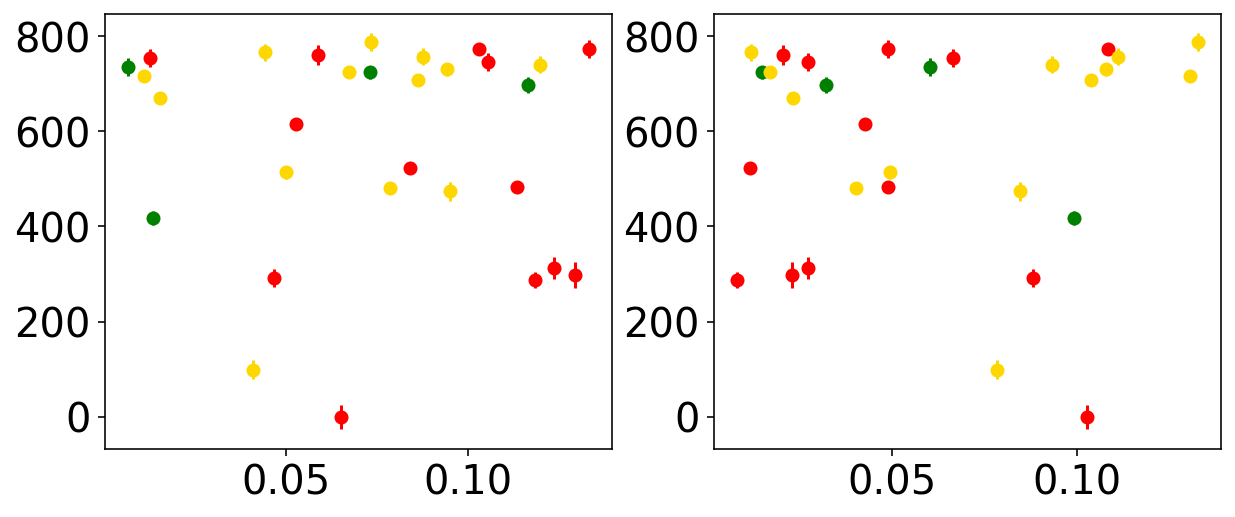

In [ ]:
#tfit = np.linspace(0, model.best_period, 1000)

magfit = model.predict(tfit, filts='g')
